# Autoencoders

In this section we are going to introduce how you can use convolution neural models (CNN) as autoencoders. Autoencoders are an interesting category of neural model which at first appear to do something trivial, which is to copy its input to its output.

## What is the point of a model that just gives you back what you give it?

So what is the point of a model that just gives you back exactly what you gave it? There are a number of possible uses of   autoencoders:
1. Image compression -- if one layer of the model uses a smaller representation than the input image then the first half of the autoencoder (up to the bottleneck) is an effective image compression algorithm.
2. Noise removal -- similarly if the autoencoder is trained to generate clean images from images that have add noise added to them it can be a very useful and efficient form of noise removal. Unfortunately, most of the time we don't have clean versions of all the images we only have noisy versions (think images from a telescope ... it is not possible to make clean images... if it was we would have built a better telescope!). But as 2. Noise removal -- similarly if the autoencoder is trained to generate clean images from images that have add noise added to them it can be a very useful and efficient form of noise removal. Unfortunately, most of the time we don't have clean versions of all the images we only have noisy versions (think images from a telescope ... it is not possible to make clean images... if it was we would have built a better telescope!). But as [NVIDIA's 2018 Noise2Noise paper](https://research.nvidia.com/publication/2018-07_Noise2Noise%3A-Learning-Image) shows if you train a model to make noisy images from noisy images the nmost effective model will actually be producing clean images!

### Dimensionality of autoencoders
Autoencoders can be broken down into two parts an encoder and a decoder. For example we could write
$$ A(x) = p_\theta \left(q_\phi\left(x\right)\right)$$
where $A(x)$ is the autoencoder which is mapping from dimension $X \rightarrow X$, $q_\phi\left(x\right)$ the encoder mapping from $X\rightarrow Z$ and $p_\theta(z)$ is the decoder mapping from $Z \rightarrow X$.

A perfect autoencoder would have the same effect as the identity matrix, $I$ on $x$. But if the dimensionality is such that $dim(Z) \lt dim(X)$, then the encoder part is effectively compressing the input (normally image) down to a lower dimensional representation.

### Latent space
In a lot of machine learning literature you will come across the term latent space to describe the reduced dimensionality in which we are able to describe the compressed input.
![Latent Space Illustration](https://hackernoon.com/hn-images/1*op0VO_QK4vMtCnXtmigDhA.png)
*Depiction of convolutional neural model. Source: Source: Hackernoon Latent Space Visualization.*


### Let's make an autoencoder

This code is heavily inspired by a tutorial from https://machine-learning-for-physicists.org and is released under the same Creative Commons License.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.18.0


In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Example 1: Circles, circles everywhere
This example isn't even a real autoencoder because it never shrinks the dimensionality of the representation. So it should in theory be possible to train it to perfection.

In [3]:
image_size=30

# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def my_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )

input_shape=(image_size,image_size,1)
#Now let's define a model to try and learn how to make these images
model=keras.Sequential()
input_layer=keras.layers.Input(shape=input_shape)
model.add(input_layer)
# 3x3 kernel size, 10 channels in first hidden layer:
model.add(keras.layers.Conv2D(10,3,activation="sigmoid",padding='same'))
# 3x3 kernel size, only 1 channel in last hidden layer:
model.add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model.compile(loss='mean_squared_error',
              optimizer='adam')
model.summary()


2025-02-07 09:27:26.699776: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-02-07 09:27:26.699816: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-02-07 09:27:26.699823: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1738920446.699837 1825244 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1738920446.699859 1825244 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 1)      │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191 (764.00 B)

 Trainable params: 191 (764.00 B)

 Non-trainable params: 0 (0.00 B)

2025-02-07 09:27:26.862027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


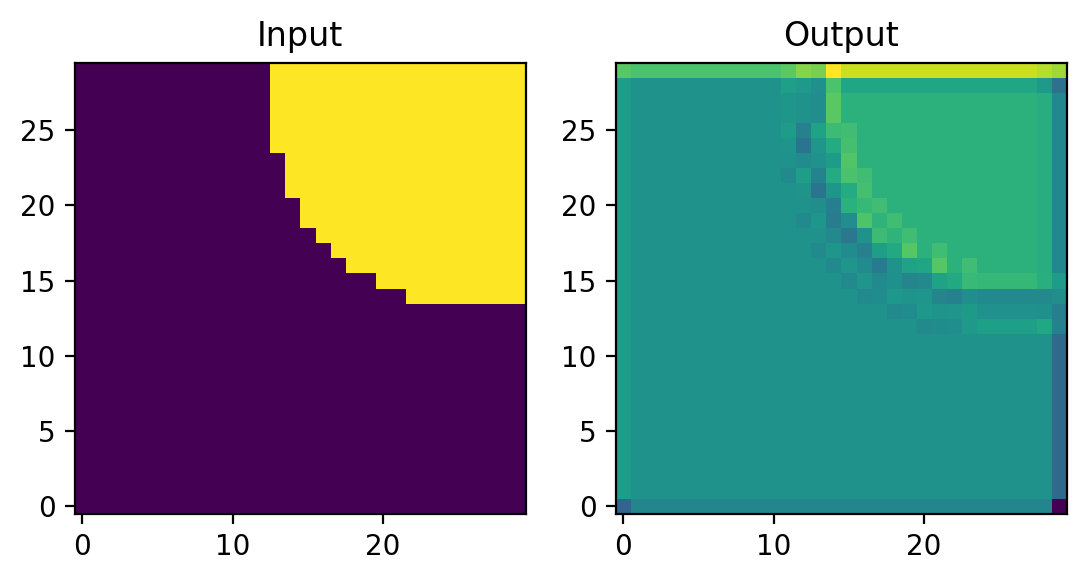

In [4]:
#Just for fun let's plot what the image looks like before any training
#Probably since our input image is just 1 or 0 the output even with random model weights and biases will
#have a circle imprint
plot_test_image(model,my_generator,image_size)

Text(0, 0.5, 'Cost')

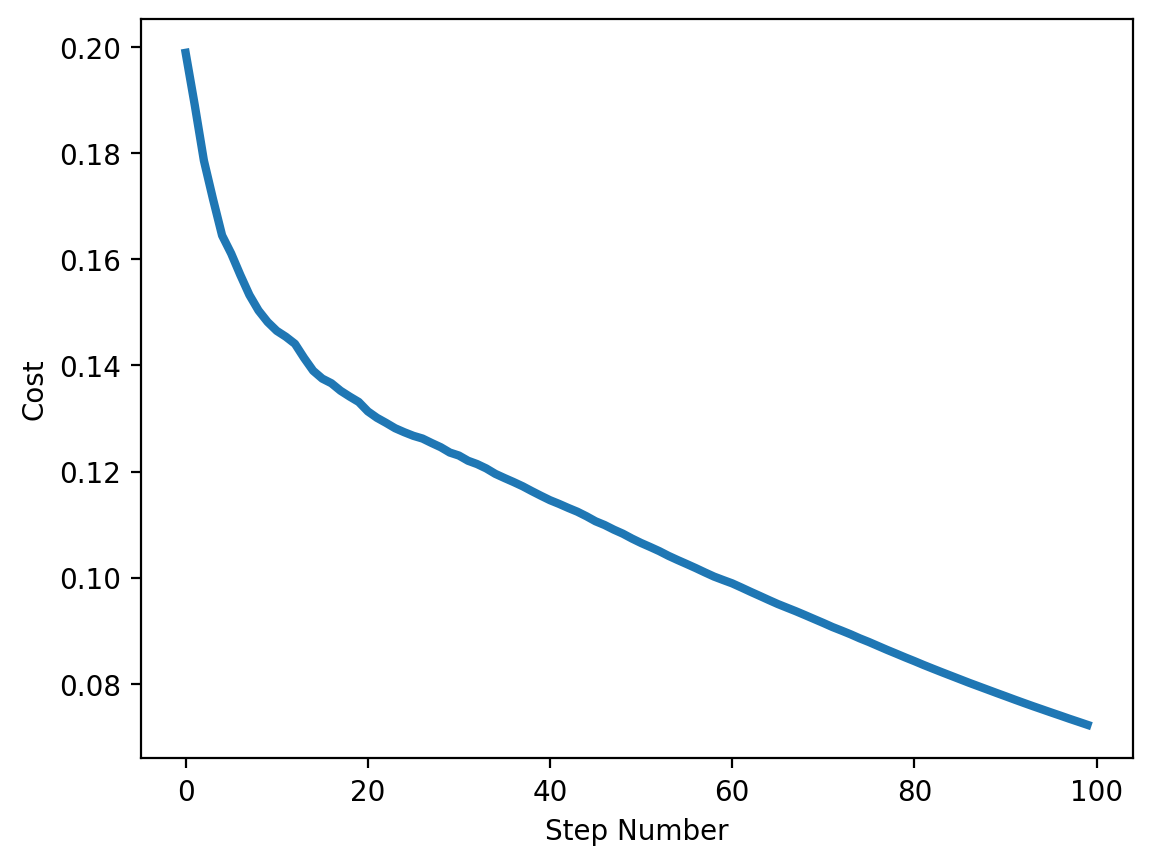

In [5]:
#Now we can do the actual model training
steps=100
cost,_=generate_and_train(model,my_generator,img_size=image_size,batchsize=100,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

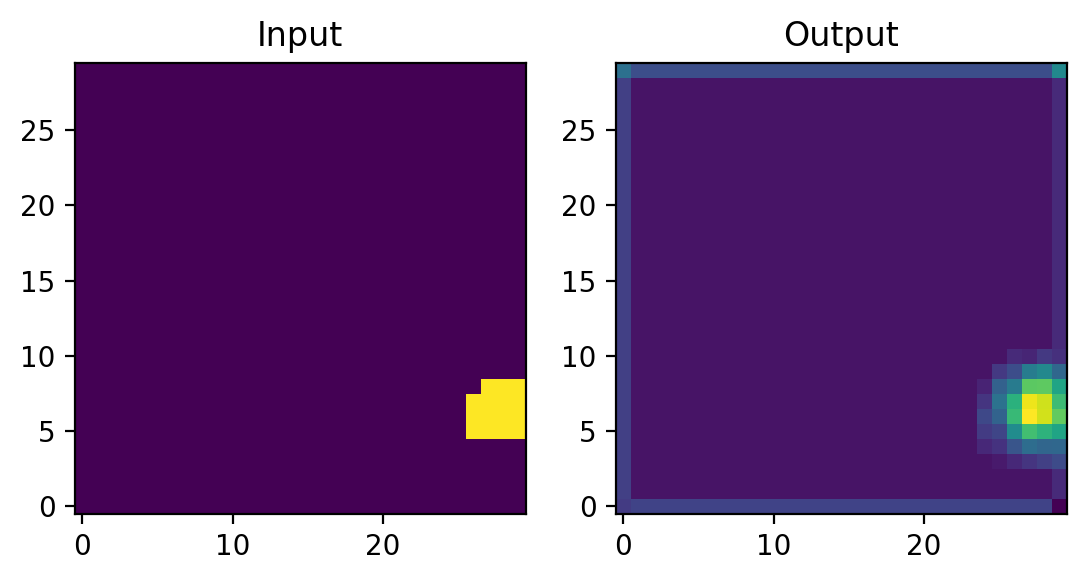

In [6]:
#And now when we look our model is probably doing a much better job of reproducing the image
plot_test_image(model,my_generator,image_size)

## But what is our network doing?
We can extract information from the layers in out neural network

In [7]:
model.summary()
layer_outputs = [layer.output for layer in model.layers[:1]] # Extracts the outputs of the hidden layer
activation_model = keras.models.Model(inputs=model.inputs, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 1)      │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575 (2.25 KB)

 Trainable params: 191 (764.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 384 (1.50 KB)

## Running the activation model in predict mode

In [8]:
#Get random test image
y_test=get_test_image(my_generator,image_size)
#Now use our activation_model on our test image
activations = activation_model.predict(y_test) 
print(activations.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 30, 30, 10)


/Users/rjn/miniforge3/envs/ml-env/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 30, 30, 1))
  warnings.warn(msg)


The shape of the activations is a $30 \times 30$ with 10 channels. Now we can plot one of these channels.

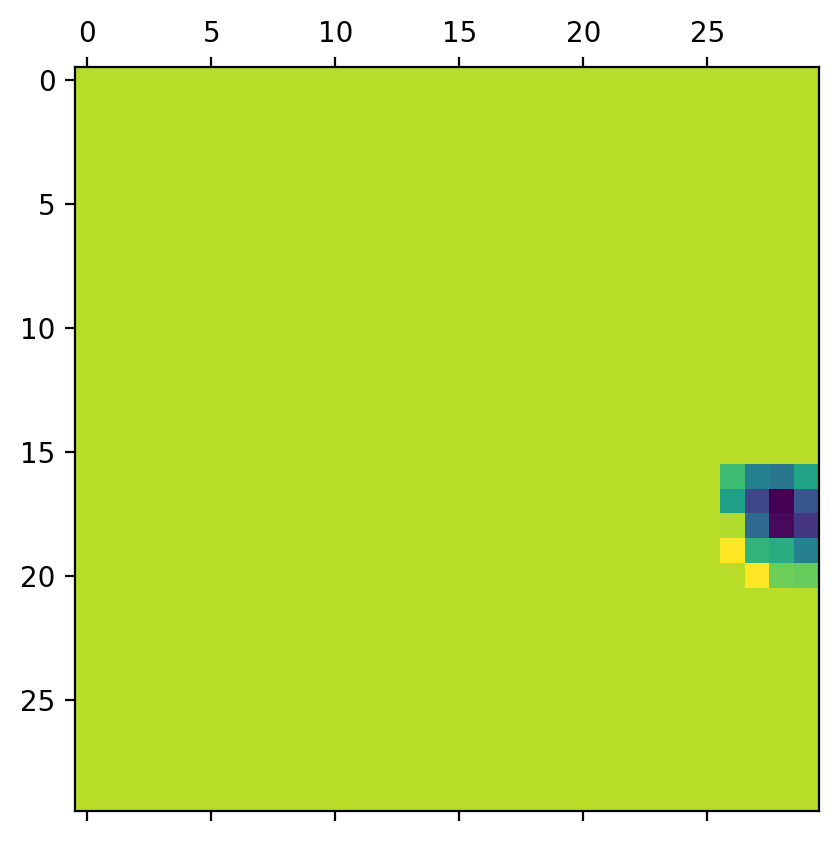

In [9]:
plt.matshow(activations[0, :, :, 4], cmap='viridis')

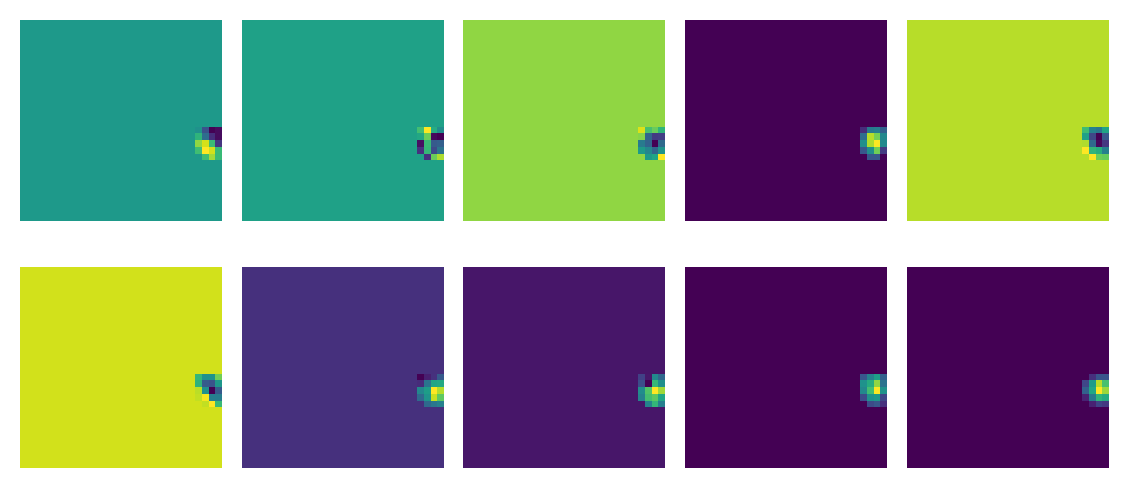

In [10]:
#There are 10 channels in the hidden layer so we will plot the channels
# in a 5x2 grid
fig, ax = plt.subplots(nrows=2, ncols=5)  #Make the subplot array
for i in range(10):  #Loop over the channels
    row=int(i/5)
    col=int(i%5)
    ax[row,col].set_axis_off()
    ax[row,col].matshow(activations[0, :, :, i], cmap='viridis')  #Plot the channel
plt.subplots_adjust(left=0.05,
                    bottom=0, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.6)  #Adjust the space between the subplots so there isn't acres of whitespace

# Example 2: Let's make a bottleneck -- our first real encoder

In [11]:
model2=keras.models.Sequential()
# 3x3 kernel size, 10 channels in first hidden layer:
model2.add(keras.layers.Input(shape=(None,None,1))) #Here we don't specify the image size
model2.add(keras.layers.Conv2D(4,5,activation="sigmoid",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model2.add(keras.layers.Conv2D(4,5,
               activation="sigmoid",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model2.add(keras.layers.Conv2D(1,3,
               activation="sigmoid",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(4,5,
               activation="sigmoid",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(4,5,
               activation="sigmoid",padding='same'))
model2.add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model2.compile(loss='mean_squared_error',
              optimizer='adam')
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, None, None, 4)  │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, None, None, 4)  │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None, 4)  │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, None, None, 4)  │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None, 1)  │            37 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, None, None, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None, 4)  │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, None, None, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, None, 4)  │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, None, 1)  │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,090 (4.26 KB)

 Trainable params: 1,090 (4.26 KB)

 Non-trainable params: 0 (0.00 B)

Text(0, 0.5, 'Cost')

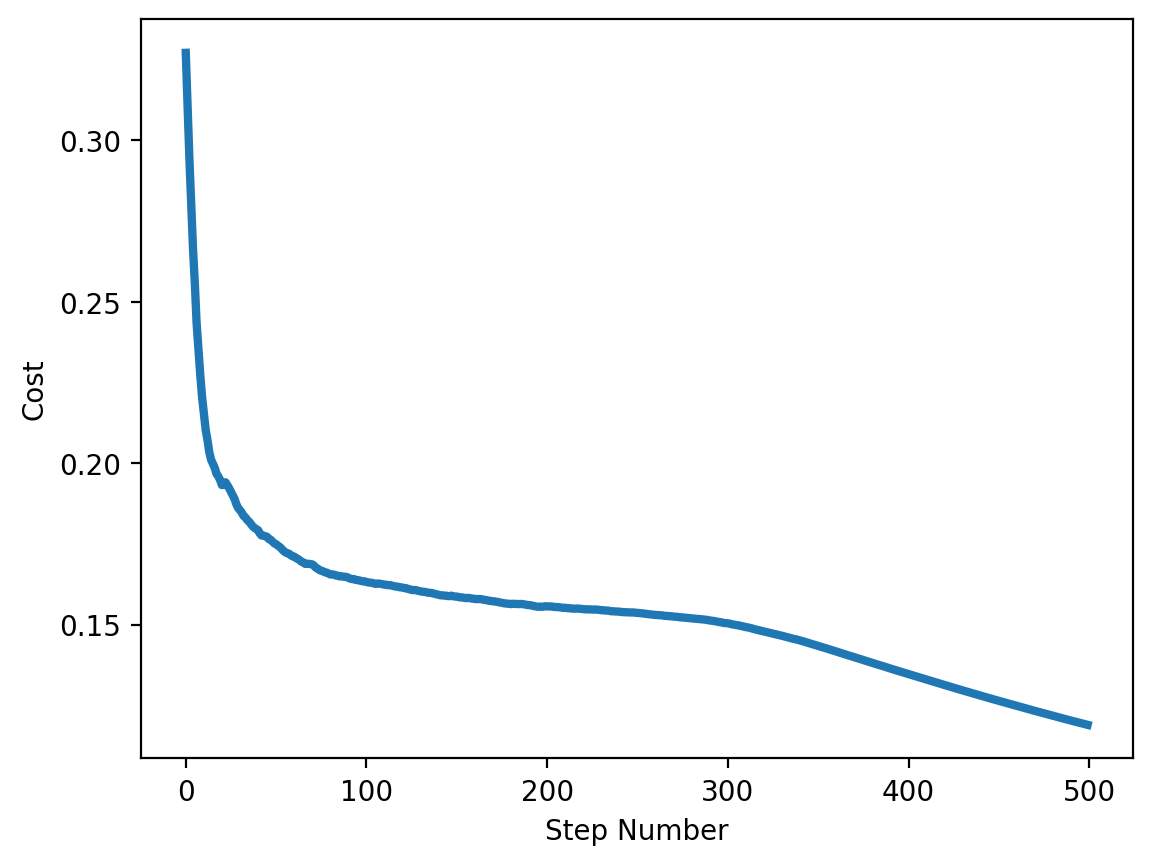

In [12]:
#Now we can do the actual model training
steps=500
cost,y_target=generate_and_train(model2,my_generator,img_size=9*3,batchsize=100,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

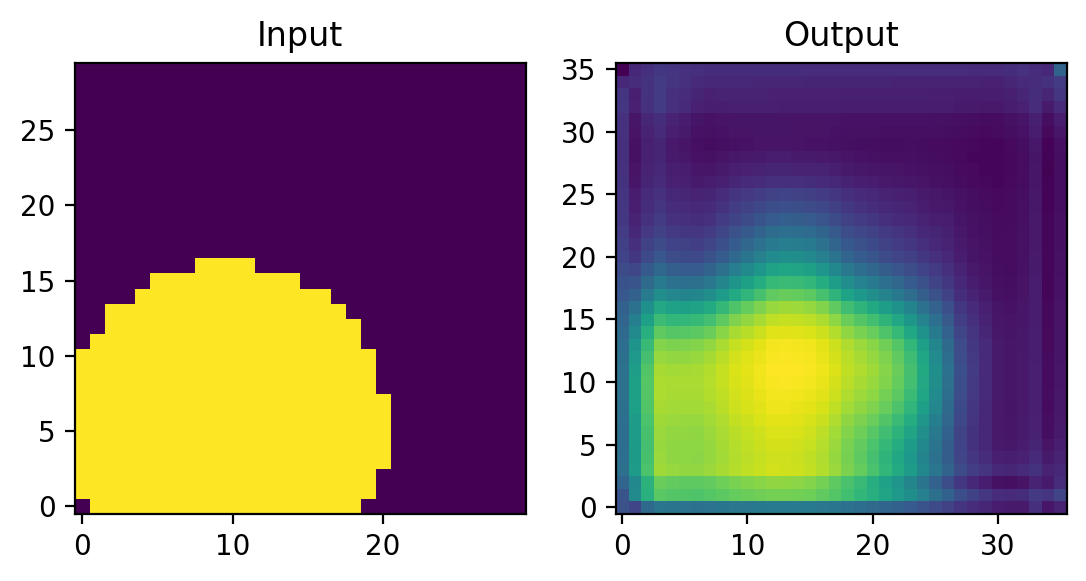

In [13]:
#And now when we look our model is probably doing a much better job of reproducing the image
plot_test_image(model2,my_generator,30)

In [14]:
print_layers(model2,y_target)

Layer 0: 2916 neurons /  (100, 27, 27, 4)
Layer 1: 324 neurons /  (100, 9, 9, 4)
Layer 2: 324 neurons /  (100, 9, 9, 4)
Layer 3: 36 neurons /  (100, 3, 3, 4)
Layer 4: 9 neurons /  (100, 3, 3, 1)
Layer 5: 81 neurons /  (100, 9, 9, 1)
Layer 6: 324 neurons /  (100, 9, 9, 4)
Layer 7: 2916 neurons /  (100, 27, 27, 4)
Layer 8: 2916 neurons /  (100, 27, 27, 4)
Layer 9: 729 neurons /  (100, 27, 27, 1)


/Users/rjn/miniforge3/envs/ml-env/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4']
Received: inputs=Tensor(shape=(100, 27, 27, 1))
  warnings.warn(msg)


In [15]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, None, None, 4)  │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, None, None, 4)  │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None, 4)  │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, None, None, 4)  │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None, 1)  │            37 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, None, None, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None, 4)  │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, None, None, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, None, 4)  │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, None, 1)  │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,272 (12.79 KB)

 Trainable params: 1,090 (4.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,182 (8.53 KB)

['conv2d_2', 'average_pooling2d', 'conv2d_3', 'average_pooling2d_1', 'conv2d_4', 'up_sampling2d', 'conv2d_5', 'up_sampling2d_1', 'conv2d_6', 'conv2d_7']


/Users/rjn/miniforge3/envs/ml-env/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4']
Received: inputs=Tensor(shape=(1, 30, 30, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


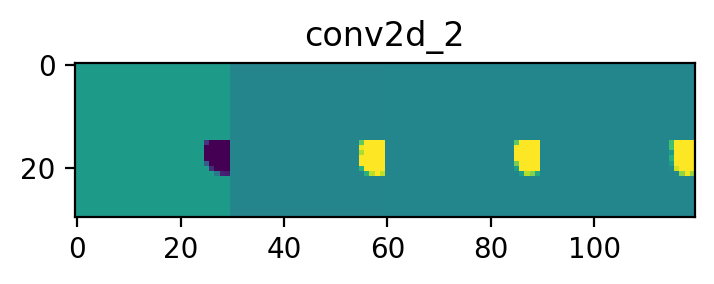

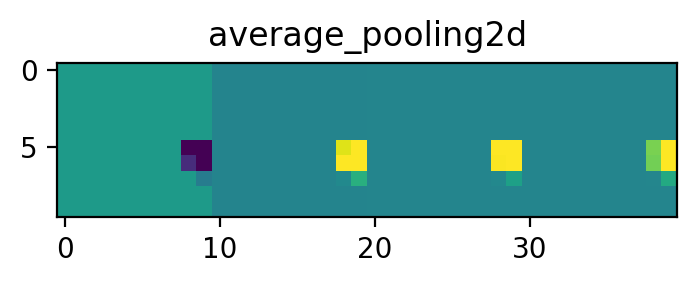

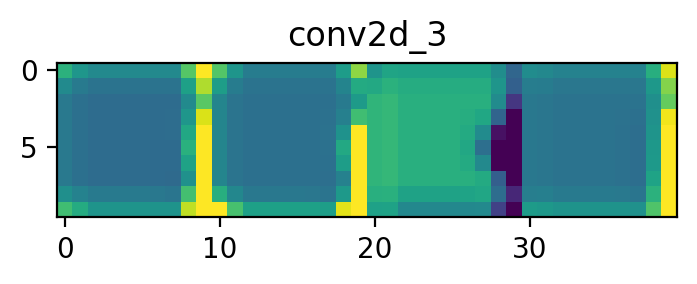

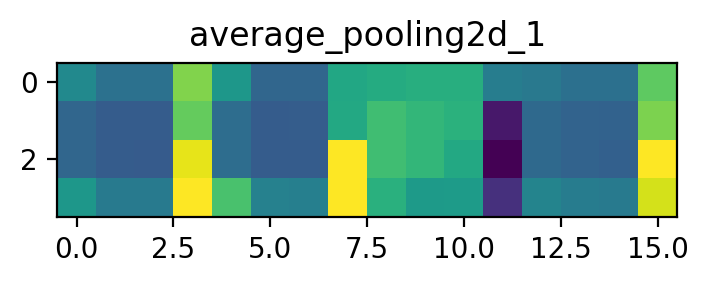

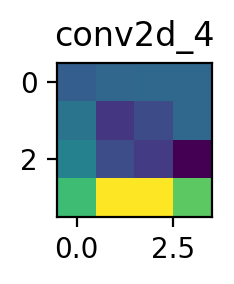

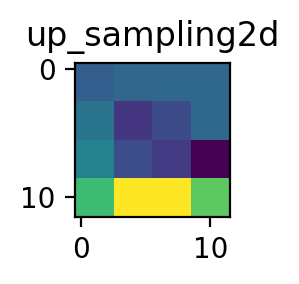

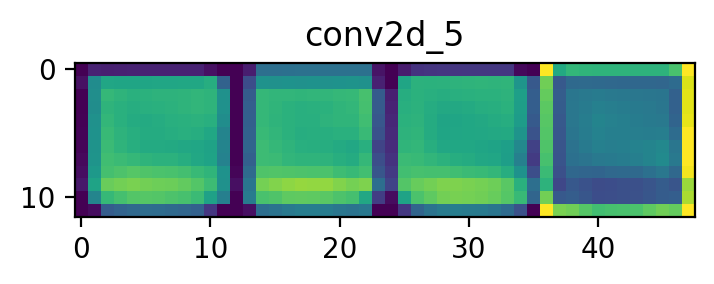

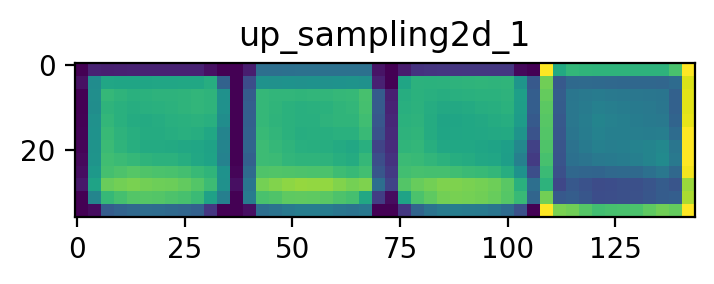

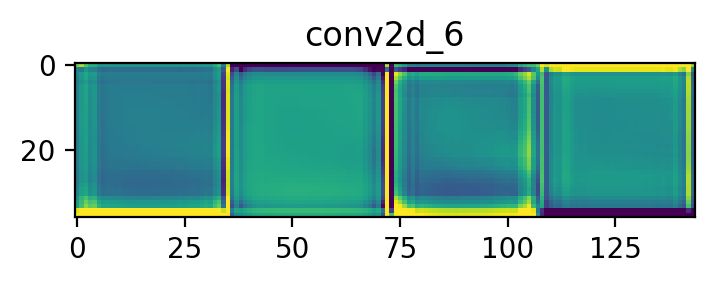

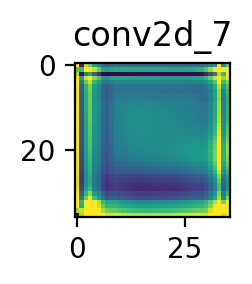

In [16]:
#This function had its plotting routine take from https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0
#The function takes a trained neural network model and a test image and plots the activations at each layer for each channel in the network
def plot_intermediate_layers(model,test_img,images_per_row=4):
    layer_names = []
    for layer in model.layers[:]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    print(layer_names)

    layer_outputs = [layer.output for layer in model.layers[:]] # Extracts the outputs of the hidden layer
    activation_model = keras.models.Model(inputs=model.inputs, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
    activations = activation_model.predict(test_img) 
   
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_rows = n_features // images_per_row # Tiles the activation channels in this matrix
        if(n_rows==0):
            n_rows=1
    
        display_grid = np.zeros((size * n_rows, min(images_per_row,n_features) * size))
        #print(display_grid.shape)
        #print(layer_name, "n_features",n_features,size,n_cols)

        for i in range(n_features):
            row = i // images_per_row
            col = i % images_per_row
            channel_image = layer_activation[0,:, :,i]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[ row * size : (row + 1) * size,col * size : (col + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
plot_intermediate_layers(model2,y_test)

## Summary 
So our autoencoder manages to have a bottleneck which is just 9 neurons wide but still manages to roughly reproduce our input images.

### Tutorials
1. What happens if you change the acctivation function from `sigmoid` to `relu`?
2. Change the generator for different kinds of images